In [1]:
import pandas as pd
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")
print("Dimensions of train: {}".format(train.shape))
print("Dimensions of test: {}".format(test.shape))

Dimensions of train: (891, 12)
Dimensions of test: (418, 11)


In [2]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


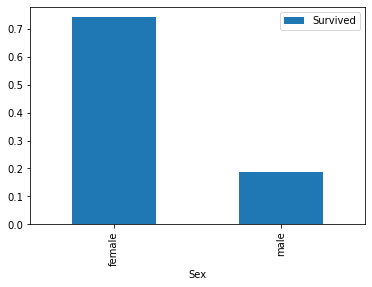

In [3]:
import matplotlib.pyplot as plt

sex_pivot = train.pivot_table(index="Sex",values="Survived")
sex_pivot.plot.bar()
plt.show()

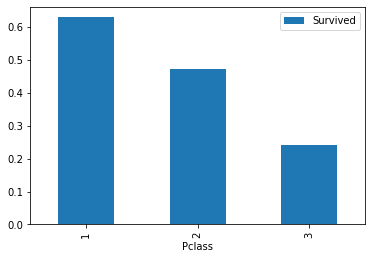

In [4]:
class_pivot = train.pivot_table(index="Pclass",values="Survived")
class_pivot.plot.bar()
plt.show()

In [5]:
train["Age"].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

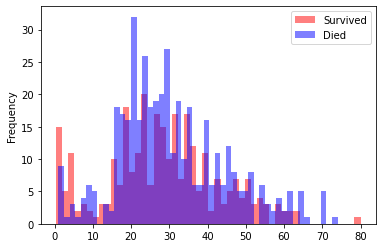

In [6]:
survived = train[train["Survived"] == 1]
died = train[train["Survived"] == 0]
survived["Age"].plot.hist(alpha=0.5,color='red',bins=50)
died["Age"].plot.hist(alpha=0.5,color='blue',bins=50)
plt.legend(['Survived','Died'])
plt.show()

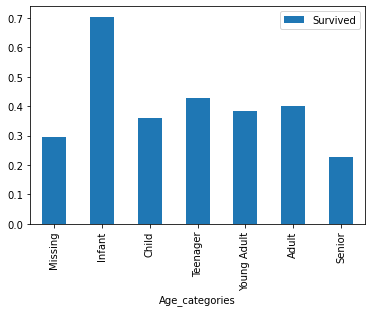

In [7]:
def process_age(df,cut_points,label_names):
    df["Age"] = df["Age"].fillna(-0.5)
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

cut_points = [-1,0,5,12,18,35,60,100]
label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
train = process_age(train,cut_points,label_names)
test = process_age(test,cut_points,label_names)

pivot = train.pivot_table(index="Age_categories",values='Survived')
pivot.plot.bar()
plt.show()

## Preparing our data for machine learning

In [8]:
train["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [9]:
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

for column in ["Pclass","Sex","Age_categories"]:
    train = create_dummies(train,column)
    test = create_dummies(test,column)

## Creating our first machine learning model

In [10]:
from sklearn.linear_model import LogisticRegression

In [11]:
lr = LogisticRegression()

In [12]:
columns = ['Pclass_2', 'Pclass_3', 'Sex_male']
lr.fit(train[columns], train['Survived'])

LogisticRegression()

In [13]:
from sklearn.linear_model import LogisticRegression

columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing','Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
      'Age_categories_Senior']

lr = LogisticRegression()
lr.fit(train[columns], train["Survived"])

LogisticRegression()

In [14]:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(multi_class='ovr', n_jobs=1, solver='liblinear')

## Splitting our training data

In [15]:
holdout = test # from now on we will refer to this
               # dataframe as the holdout data

from sklearn.model_selection import train_test_split

all_X = train[columns]
all_y = train['Survived']

train_X, test_X, train_y, test_y = train_test_split(
    all_X, all_y, test_size=0.20,random_state=0)

## Making predictions and measuring their accuracy

In [16]:
lr = LogisticRegression()
lr.fit(train_X, train_y)
predictions = lr.predict(test_X)

In [17]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_y, predictions)

In [18]:
from sklearn.metrics import accuracy_score
lr = LogisticRegression()
lr.fit(train_X, train_y)
predictions = lr.predict(test_X)
accuracy = accuracy_score(test_y, predictions)
print(accuracy)

0.8100558659217877


## Using cross validation for more accurate error measurement

In [22]:
from sklearn.model_selection import cross_val_score

lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y, cv=10)
scores.sort()
accuracy = scores.mean()

print(scores)
print(accuracy)

[0.76404494 0.76404494 0.76404494 0.78651685 0.8        0.80898876
 0.80898876 0.82022472 0.83146067 0.87640449]
0.8024719101123596


In [23]:
lr = LogisticRegression()
lr.fit(all_X,all_y)
holdout_predictions = lr.predict(holdout[columns])

## Creating a sublesson file

In [24]:
holdout_ids = holdout["PassengerId"]
sublesson_df = {"PassengerId": holdout_ids,
                 "Survived": holdout_predictions}
sublesson = pd.DataFrame(sublesson_df)

In [25]:
sublesson.to_csv("sublesson.csv",index=False)